In [26]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [27]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

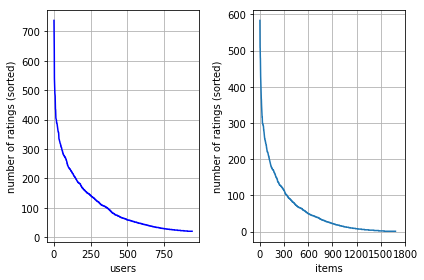

min # of items per user = 20, min # of users per item = 1.


In [28]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [29]:
def split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test = 0.1):
    """
    Splits the valid ratings to training and test data.
    Args:
        ratings: raw ratings data
        num_items_per_user: a list denoting the number of ratings each user gave
        num_items_per_user: a list denoting the number of ratings each item received
        min_num_ratings: all users and items we keep must have at least min_num_ratings 
            per user and per item. 
        p_test = ration of test data size to valid ratings data size
    Returns:
        valid_ratings: subset of raw ratings based on the condition min_num_ratings
        train_ratings: subset of valid_ratings dedicated to training
        test_ratings: subset of valid_ratings dedicated to testing
    """
    # set seed
    np.random.seed(988)
    # select user and item based on the condition
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]  
    # print shape information
    print("Shape of original ratings: {}".format(ratings.shape))
    print("Shape of valid ratings: {}".format(valid_ratings.shape))
    # initialize training and testing data
    test_ratings = sp.lil_matrix(valid_ratings.shape)
    train_ratings = sp.lil_matrix(valid_ratings.shape)
    # users with valid nonzero ratings
    nonzero_users = np.unique(valid_ratings.nonzero()[1])
    # construct train/test ratings
    for user in nonzero_users:
        items = valid_ratings[:, user].nonzero()[0]
        test_items = np.random.choice(items, int(len(items) * p_test), replace = False)
        train_items = np.setdiff1d(items, test_items)
        test_ratings[test_items, user] = valid_ratings[test_items, user]
        train_ratings[train_items, user] = valid_ratings[train_items, user]
    # print size information
    print("Total number of nonzero elements in origial data: {v}".format(v = ratings.nnz))
    print("Total number of nonzero elements in valid data: {v}".format(v = valid_ratings.nnz))
    print("Total number of nonzero elements in train data: {v}".format(v = train_ratings.nnz))
    print("Total number of nonzero elements in test data: {v}".format(v = test_ratings.nnz))
    return valid_ratings, train_ratings, test_ratings

Shape of original ratings: (1682, 943)
Shape of valid ratings: (1152, 943)
Total number of nonzero elements in origial data: 99999
Total number of nonzero elements in valid data: 97952
Total number of nonzero elements in train data: 88558
Total number of nonzero elements in test data: 9394


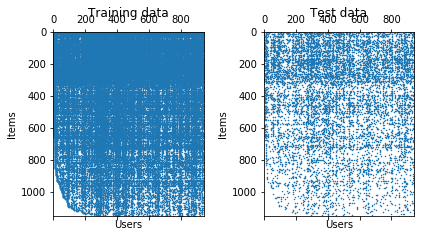

In [30]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [31]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    nonzero_train = train[train.nonzero()]
    global_mean_train = np.mean(nonzero_train)
    nonzero_test = test[test.nonzero()].toarray()
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(mse / nonzero_test.shape[1])
    print("Test RMSE using the global mean to do the prediction: {}".
          format(np.squeeze(rmse)))

baseline_global_mean(train, test)

Test RMSE using the global mean to do the prediction: 1.1165457600927071


### Use the user means as the prediction

In [32]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_users = train.shape[1]
    for user in range(num_users):
        items_train = train[:, user]
        nonzero_items_train = items_train[items_train.nonzero()]
        if nonzero_items_train.size != 0: # eliminate error case
            user_mean = np.mean(nonzero_items_train)
        else:
            continue
        items_test = test[:, user]
        nonzero_items_test = items_test[items_test.nonzero()].toarray()
        mse += calculate_mse(nonzero_items_test, user_mean)
    rmse = np.sqrt(mse / test.nnz)
    print("Test RMSE using the user mean to do the prediction: {}".
          format(np.squeeze(rmse)))

baseline_user_mean(train, test)

Test RMSE using the user mean to do the prediction: 1.0400669307419783


### Use the item means as the prediction

In [33]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items = train.shape[0]
    for item in range(num_items):
        users_train = train[item]
        nonzero_users_train = users_train[users_train.nonzero()]
        if nonzero_users_train.size != 0: # eliminate error case
            item_mean = np.mean(nonzero_users_train)
        else:
            continue
        users_test = test[item]
        nonzero_users_test = users_test[users_test.nonzero()].toarray()
        mse += calculate_mse(nonzero_users_test, item_mean)
    rmse = np.sqrt(mse / test.nnz)
    print("Test RMSE using the item mean to do the prediction: {}".
          format(np.squeeze(rmse)))
    
baseline_item_mean(train, test)

Test RMSE using the item mean to do the prediction: 1.017386654202693


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [34]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    num_movies, num_users = train.shape
    global_mean = train.sum() / train.nnz
    rating = np.sqrt(global_mean / num_features)
    movie_features = np.full((num_movies, num_features), rating, dtype=float)
    user_features = np.full((num_users, num_features), rating, dtype=float)
    return  movie_features, user_features

Compute the cost by the method of matrix factorization.


In [35]:
def compute_error(data, movie_features, user_features, nonzero_ratings):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for movie, user in nonzero_ratings:
        error = data[movie, user] - movie_features[movie].dot(user_features[user])
        mse += (error ** 2) 
    mse /= len(nonzero_ratings)
    return np.sqrt(mse) # rmse

In [36]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_movie = 0.7
    lambda_user = 0.1
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    # set seed
    np.random.seed(988)
    # init matrix
    movie_features, user_features = init_MF(train, num_features)
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        # decrease step size
        gamma /= 1.2
        for row, column in nz_train:
            movie_vector = movie_features[row]
            user_vector = user_features[column]
            error_vector = train[row, column] - movie_vector.dot(user_vector)
            movie_features[row] += 2 * gamma * (error_vector * user_vector - lambda_movie * movie_vector)
            user_features[column] += 2 * gamma * (error_vector * movie_vector - lambda_user * user_vector)
        rmse = compute_error(train, movie_features,user_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
    rmse = compute_error(test, movie_features, user_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    
matrix_factorization_SGD(train, test) 

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0133702552081834.
iter: 1, RMSE on training set: 0.9986403989839943.
iter: 2, RMSE on training set: 0.9900925688793855.
iter: 3, RMSE on training set: 0.9838713311256534.
iter: 4, RMSE on training set: 0.9735990005586606.
iter: 5, RMSE on training set: 0.9676083524235702.
iter: 6, RMSE on training set: 0.9643450026579538.
iter: 7, RMSE on training set: 0.962550508035121.
iter: 8, RMSE on training set: 0.9640417271205057.
iter: 9, RMSE on training set: 0.9634793564156328.
iter: 10, RMSE on training set: 0.9603654666756481.
iter: 11, RMSE on training set: 0.9620291680780166.
iter: 12, RMSE on training set: 0.9589718102571534.
iter: 13, RMSE on training set: 0.9586901707337944.
iter: 14, RMSE on training set: 0.9594880756203812.
iter: 15, RMSE on training set: 0.9580100015376504.
iter: 16, RMSE on training set: 0.9583017049513268.
iter: 17, RMSE on training set: 0.9582773224190705.
iter: 18, RMSE on training set:

### Learn the Matrix Factorization using Alternating Least Squares

In [37]:
def update_user_feature(
        train, movie_features, lambda_user,
        num_nonzero_columns, nonzero_entries_by_column):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    num_users = len(num_nonzero_columns)
    num_features = movie_features.shape[1]
    lambda_I = lambda_user * sp.eye(num_features)
    updated_user_features = np.zeros((num_users, num_features))
    for user, movies in nonzero_entries_by_column:
        # extract the columns corresponding to the prediction for given user
        Z = movie_features[movies]
        Z_T_Z_regularized = Z.T.dot(Z) + num_nonzero_columns[user] * lambda_I
        X = train[movies, user]
        X_Z = X.T.dot(Z)
        W_star = np.linalg.solve(Z_T_Z_regularized, X_Z.T)
        updated_user_features[user] = W_star.T
    return updated_user_features

def update_movie_feature(
        train, user_features, lambda_movie,
        num_nonzero_rows, nonzero_entries_by_row):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_movies = len(num_nonzero_rows)
    num_features = user_features.shape[1]
    lambda_I = lambda_movie * sp.eye(num_features)
    updated_movie_features = np.zeros((num_movies, num_features))
    for movie, users in nonzero_entries_by_row:
        # extract the columns corresponding to the prediction for given user
        Z = user_features[users]
        Z_T_Z_regularized = Z.T.dot(Z) + num_nonzero_rows[movie] * lambda_I
        X = train[movie, users]
        X_Z = X.dot(Z)
        W_star = np.linalg.solve(Z_T_Z_regularized, X_Z.T)
        updated_movie_features[movie] = W_star.T
    return updated_movie_features

In [39]:
from helpers import build_index_groups

def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_movie = 0.7
    lambda_user = 0.1
    stop_criterion = 1e-4
    change = 1
    rmses = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    movie_features, user_features = init_MF(train, num_features)
    num_nonzero_rows, num_nonzero_columns = train.getnnz(axis = 1), train.getnnz(axis = 0)
    nonzero_entries, nonzero_entries_by_row, nonzero_entries_by_column = build_index_groups(train)
    
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update movie features
        user_features = update_user_feature(
            train, movie_features, lambda_user,
            num_nonzero_columns, nonzero_entries_by_column)
        movie_features = update_movie_feature(
            train, user_features, lambda_movie,
            num_nonzero_rows, nonzero_entries_by_row)
        # update user features
        rmse = compute_error(train, movie_features, user_features, nonzero_entries)
        print("RMSE on training set: {}.".format(rmse))
        rmses.append(rmse)
        change = np.fabs(rmses[-1] - rmses[-2])
    # evaluate the test error
    nonzero_rows_test, nonzero_columns_test = test.nonzero()
    nonzero_entries_test = list(zip(nonzero_rows_test, nonzero_columns_test))
    rmse = compute_error(test, movie_features, user_features, nonzero_entries_test)
    print("test RMSE after running ALS: {}.".format(rmse))   

ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.1154859305150537.
RMSE on training set: 1.0327275252410064.
RMSE on training set: 1.0009762483721891.
RMSE on training set: 0.9841575626976294.
RMSE on training set: 0.9742617640515616.
RMSE on training set: 0.968054601628451.
RMSE on training set: 0.9639902275165931.
RMSE on training set: 0.9612482055458758.
RMSE on training set: 0.9593587295922176.
RMSE on training set: 0.9580368437929552.
RMSE on training set: 0.9571018927921913.
RMSE on training set: 0.9564353721976415.
RMSE on training set: 0.955957485834175.
RMSE on training set: 0.9556134206428784.
RMSE on training set: 0.9553649537841957.
RMSE on training set: 0.955185128866586.
RMSE on training set: 0.9550547746925692.
RMSE on training set: 0.9549601717374204.
test RMSE after running ALS: 0.979581109435704.
